In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scanpy as sc
import cassiopeia as cas
import seaborn as sns
import statistics as stats
import collections
import pickle
import scipy.sparse as sp_sparse
import scipy.io

from matplotlib.pyplot import rc_context
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pylab import *
from ete3 import Tree
from typing import Tuple

In [2]:
clusterColorsFile = "/Genomics/chanlab/mchan/Adriano/TLS/TLS_TLSCL/20211102_clusterColorsTLSCL.p"
with open(clusterColorsFile,'rb') as fp:
    colorDict = pickle.load(fp)

In [3]:
# Load the allele table, tree, and lineage table for TLS1
TLS1_allele_table = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/allele_table.txt', sep='\t')

TLS1_loc = '/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/AM-DNA-097_hybrid_newick_noMutationlessEdges_Labeled.nwk'
t = Tree(TLS1_loc, format=1)

lineage_table = pd.read_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/2_lineage_reconstruction/AM-DNA-097_lineage_table.txt', sep = '\t')

cell_state_table = pd.read_csv('/Genomics/chanlab/blaw/TLS/LineageTracer/scRNAseq/TLS_120h_1_cellBC_cellState.tsv', sep='\t')

#TLS1 = sc.read_h5ad('/Genomics/chanlab/blaw/TLS/raw_data/scRNA/TLS12/TLS_120h_1.h5ad')

In [4]:
def maxDepth(node):
    '''
    Input:
        - a node in an ete tree
    returns:
        - The max depth of any branch in that node
    '''
    if node.is_leaf():
        return 0
    children_depths = []
    
    for child in node.children:
        test = maxDepth(child)
        
        children_depths.append(test)
        
    return max(children_depths) + 1

In [5]:
# Find all the nodes in TLS1
nodes = []
for node in t.traverse():
    if not node.is_leaf():
        if node.name != 'node0':
            nodes.append(node.name)

In [6]:
node_info = pd.DataFrame(index = nodes, columns = ['Clone', 'Dist to Clone', 'Clone Depth', 'Progenitor Type', 'Normalized Dist'])

In [7]:
for clone in t.children:
    clone_depth = maxDepth(clone)
    
    for node in clone.traverse():
        if not node.is_leaf():
            dist_to_clone = t.get_distance(clone, node)
            
            node_info.loc[node.name]['Clone'] = clone.name
            node_info.loc[node.name]['Dist to Clone'] = dist_to_clone
            node_info.loc[node.name]['Clone Depth'] = clone_depth
            node_info.loc[node.name]['Normalized Dist'] = dist_to_clone / clone_depth

In [8]:
for clone in t.children:
    if not clone.is_leaf():
        node_info.loc[clone.name]['Progenitor Type'] = 'Clone'

### Label Progenitor Types:

In [9]:
def getProgenitorType(node, cell_state_table):
    '''
    input:
        - a tree node to test
        - a table that contains the annotated cell state for each cellBC
    output:
        - the type of progenitor that we are classifying it as given these criteria:
    
    - Extended progenitors: PGCs, Endoderm, Somitic, Neural
    - Pluripotent progenitors: Endoderm, Somitic, Neural
    - Bipotent progenitors: Somitic, Neural (both if contains or not NMPs still count)
    - Neural Committed: Neural + NMP
    - Somitic Committed: Somitic + NMP
    - Endoderm progenitors: Endoderm only
    - PGCLC progenitors: PGCLC only
    - Somitic progenitors: somitic only
    - Neural progenitors: neural only
    
    Neural class is made from NeuralTube1 and NeuralTube2
    Somite class is pPSM, aPSM, Somite-1, Somite0, Somite, Somite1, SomiteSclero, SomiteDermo
    
    NMPs are left out of the analysis. +/- an NMP does not change the category that a node gets
    
    exclude nodes that are Endoderm without both somitic and neural (unless it is alone)
    exclude nodes that are PGC without all 3 endoderm, somitic, and neural (unless it is alone)
    
    '''
    progenitor_types = {'Extended Progenitor': set(['PCGLC', 'Endoderm', 'Somitic', 'Neural']),
                        'Pluripotent Progenitor': set(['Endoderm', 'Somitic', 'Neural']),
                        'Bipotent Progenitor' : set(['Somitic', 'Neural']),
                        'Endoderm Progenitor': set(['Endoderm']),
                        'PGCLC Progenitor': set(['PCGLC']),
                        'Somitic Progenitor': set(['Somitic']),
                        'Neural Progenitor': set(['Neural'])}
    
    
    leaves = [leaf.name for leaf in node.get_leaves()]
    
    # make a list of the cell states in a given node
    cell_types = cell_state_table[cell_state_table['cellBC'].isin(leaves)]['cell_state'].to_list()
    
    # Group the cell states into neural and somite categories
    grouped_states = []
    for state in cell_types:
        if state in ['pPSM', 'aPSM', 'Somite', 'Somite0', 'Somite1', 'Somite-1', 'SomiteSclero', 'SomiteDermo']:
            grouped_states.append('Somitic')
        elif state in ['NeuralTube1', 'NeuralTube2']:
            grouped_states.append('Neural')
        elif state in ['PCGLC', 'Endoderm']:
            grouped_states.append(state)
    
    state_set = set(grouped_states)
    
    for progenitor in progenitor_types.keys():
        if state_set == progenitor_types[progenitor]:
            return progenitor
    
    return 'Dropped'

In [11]:
# For each node that is not a clone, record the progenitor type
for clone in t.children:
    for node in clone.traverse():
        if not node.is_leaf():
            node_info.loc[node.name]['Progenitor Type'] = getProgenitorType(node, cell_state_table)

In [12]:
# test excluding clones that are below 5 cells
clones_below5 = []
# test excluding nodes that are in clone 12 (the large rake)
nodes_in_12 = []
for clone in t.children:
    if not clone.is_leaf():
        if len(clone.get_leaves()) < 5:
            for node in clone.traverse():
                if not node.is_leaf():
                    clones_below5.append(node.name)
        if clone.name == 'node12':
            for node in clone.traverse():
                if not node.is_leaf():
                    nodes_in_12.append(node.name)

In [13]:
node_info_above5 = node_info.drop(index = clones_below5).copy()
node_info_without12 = node_info.drop(index = nodes_in_12).copy()

In [15]:
# Save all 3 tables
node_info.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/progenitor_analysis/node_progenitor_types.txt', sep = '\t')
node_info_above5.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/progenitor_analysis/node_progenitor_types_above5.txt', sep = '\t')
node_info_without12.to_csv('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/progenitor_analysis/node_progenitor_types.txt', sep = '\t')

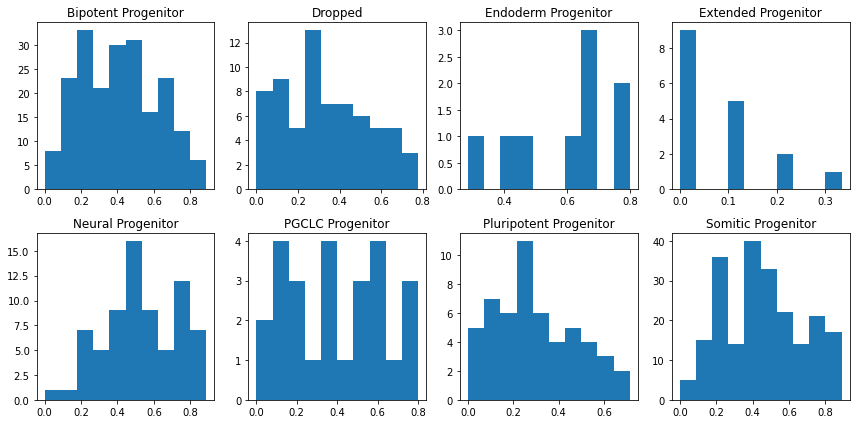

In [16]:
fig, ax = plt.subplots(2, 4, figsize = (12, 6))

count_1 = 0
count_2 = 0
for progenitor in np.unique(node_info['Progenitor Type']):
    test_ax = ax[count_2, count_1]
    count_1 += 1
    if count_1 > 3:
        count_2 = 1
        count_1 = 0

    test_ax.hist(node_info[node_info['Progenitor Type'] == progenitor]['Normalized Dist'])
    test_ax.set_title(progenitor)
plt.tight_layout()    
plt.show()
plt.close()

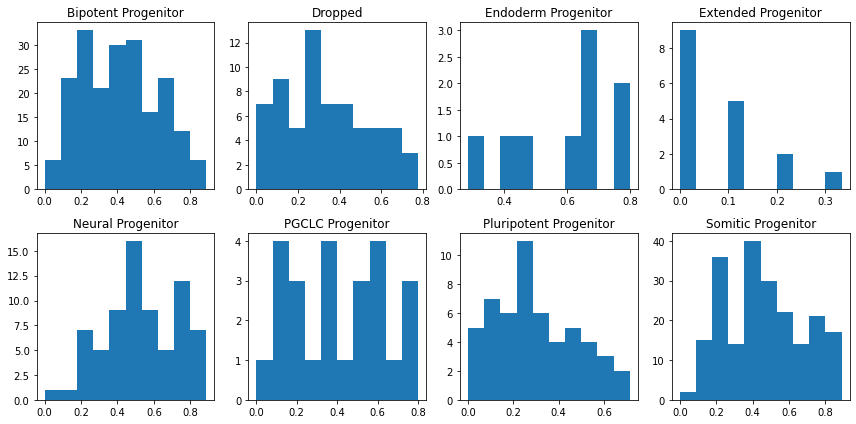

In [17]:
fig, ax = plt.subplots(2, 4, figsize = (12, 6))

count_1 = 0
count_2 = 0
for progenitor in np.unique(node_info_above5['Progenitor Type']):
    test_ax = ax[count_2, count_1]
    count_1 += 1
    if count_1 > 3:
        count_2 = 1
        count_1 = 0

    test_ax.hist(node_info_above5[node_info_above5['Progenitor Type'] == progenitor]['Normalized Dist'])
    test_ax.set_title(progenitor)
plt.tight_layout()    
plt.show()
plt.close()

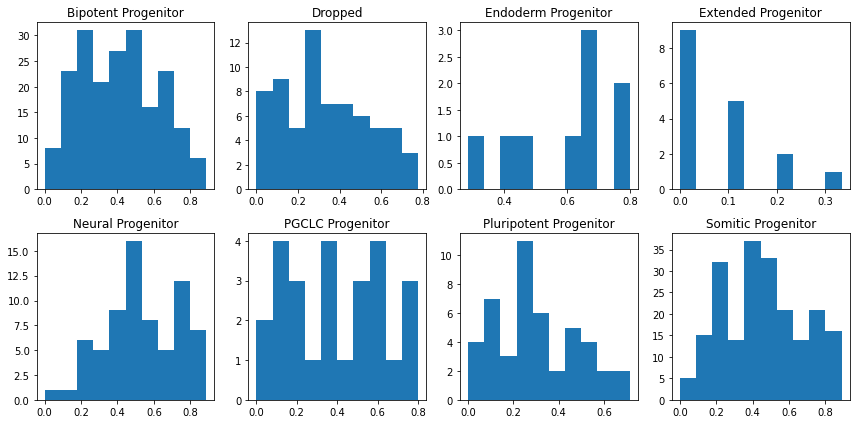

In [20]:
fig, ax = plt.subplots(2, 4, figsize = (12, 6))

count_1 = 0
count_2 = 0
for progenitor in np.unique(node_info_without12['Progenitor Type']):
    test_ax = ax[count_2, count_1]
    count_1 += 1
    if count_1 > 3:
        count_2 = 1
        count_1 = 0

    test_ax.hist(node_info_without12[node_info_without12['Progenitor Type'] == progenitor]['Normalized Dist'])
    test_ax.set_title(progenitor)
plt.tight_layout()    
plt.show()
plt.close()

# Removing nodes with less than 5 cells, or removing the large rake do not make a large difference in the distributions of progenitor nodes

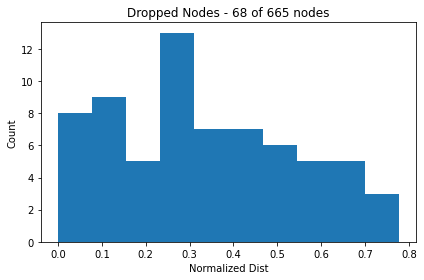

In [23]:
plt.hist(node_info[node_info['Progenitor Type'] == 'Dropped']['Normalized Dist'])
plt.xlabel('Normalized Dist')
plt.ylabel('Count')
plt.title('Dropped Nodes - {} of {} nodes'.format(len(node_info[node_info['Progenitor Type'] == 'Dropped']), len(node_info)))
plt.tight_layout()
plt.show()
plt.close()

In [24]:
node_info['Normalized Dist'] = node_info['Normalized Dist'].astype('float')
node_info_without12['Normalized Dist'] = node_info_without12['Normalized Dist'].astype('float')
node_info_above5['Normalized Dist'] = node_info_above5['Normalized Dist'].astype('float')

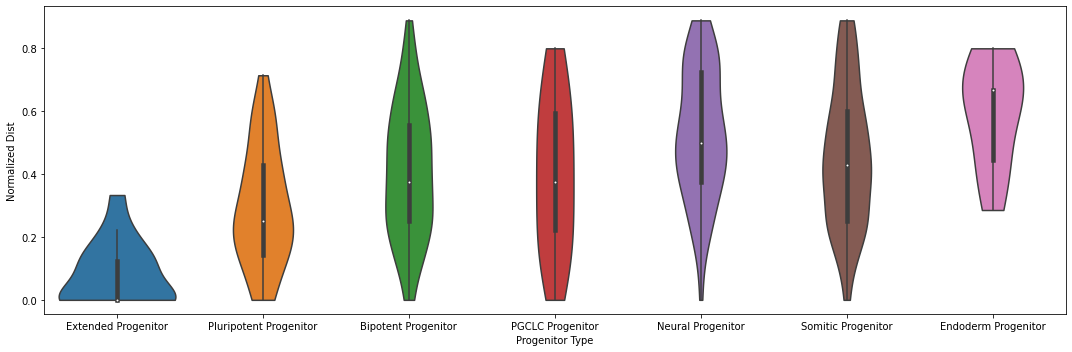

In [28]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.violinplot(ax = ax, data = node_info[node_info['Progenitor Type'] != 'Dropped'], x = 'Progenitor Type', y = 'Normalized Dist', scale = 'area', cut = 0,
               order = ['Extended Progenitor', 'Pluripotent Progenitor', 'Bipotent Progenitor', 'PGCLC Progenitor', 'Neural Progenitor', 'Somitic Progenitor', 'Endoderm Progenitor'])
plt.title('TLS1 Node')
plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/progenitor_analysis/AM-DNA-097_Progenitor_Normalized_Depth.pdf', dpi = 300)
plt.show()
plt.close()

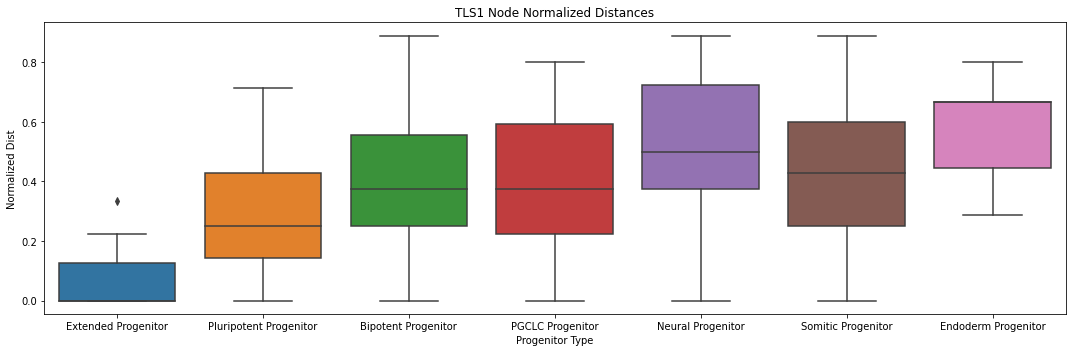

In [29]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(ax = ax, data = node_info[node_info['Progenitor Type'] != 'Dropped'], x = 'Progenitor Type', y = 'Normalized Dist',
               order = ['Extended Progenitor', 'Pluripotent Progenitor', 'Bipotent Progenitor', 'PGCLC Progenitor', 'Neural Progenitor', 'Somitic Progenitor', 'Endoderm Progenitor'])
plt.title('TLS1 Node Normalized Distances')
plt.tight_layout()
plt.savefig('/Genomics/chanlab/blaw/TLS/data/AM-DNA-097/lineage/Progenitor_Depths.pdf', dpi = 300)
plt.show()
plt.close()